# Лабораторная работа 4 | Павлов Иван М80-407Б-21

## 2.1	Создание бейзлайна и оценка качества (регрссия)

### Импорт необходимых библиотек

In [180]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [181]:
df_train = pd.read_csv('data/df_train.csv')
df_test = pd.read_csv('data/df_test.csv')

df_train.head()

,date,price,bedrooms,grade,has_basement,living_in_m2,renovated,nice_view,perfect_condition,real_bathrooms,has_lavatory,single_floor,month,quartile_zone
0,2014-05-15,312000.0,2,2,True,138.42547,False,False,False,2,True,False,5,1
1,2014-11-14,310000.0,2,2,False,105.90942,False,False,False,1,True,False,11,3
2,2014-12-24,320000.0,2,2,False,117.98681,False,True,False,1,False,True,12,2
3,2015-02-22,264500.0,2,3,False,151.43189,False,False,False,2,True,True,2,1
4,2015-01-06,700000.0,3,2,True,341.88304,False,False,False,3,False,False,1,4


In [182]:
X_train = df_train.drop(columns=['price', 'date'])
y_train = df_train['price']

X_test = df_test.drop(columns=['price', 'date'])
y_test = df_test['price']

model = RandomForestRegressor(random_state=0, n_estimators=100)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)


y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
    
print("Оценка для модели:")
print(f"Среднеквадратичная ошибка (MSE): {mse:.2f}")
print(f"Средняя абсолютная ошибка (MAE): {mae:.2f}")
print(f"Корень среднеквадратичной ошибки (RMSE): {rmse:.2f}")
print(f"Коэффициент детерминации (R^2): {r2:.2f}")

Оценка для модели:
Среднеквадратичная ошибка (MSE): 11733930099.60
Средняя абсолютная ошибка (MAE): 78532.56
Корень среднеквадратичной ошибки (RMSE): 108323.27
Коэффициент детерминации (R^2): 0.73


## 3.1	Улучшение бейзлайна (регрссия)

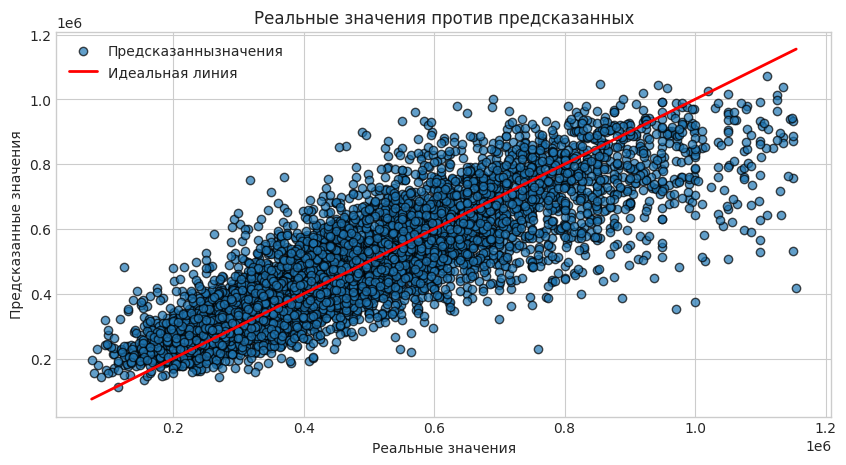

In [183]:
plt.figure(figsize=(10, 5)) 
plt.scatter(y_test, y_pred, alpha=0.7, edgecolors="k", label='Предсказаннызначения') 
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],  color='red', lw=2, label='Идеальная линия') 
plt.xlabel('Реальные значения') 
plt.ylabel('Предсказанные значения') 
plt.title('Реальные значения против предсказанных') 
plt.legend() 
plt.grid(True) 
plt.show()

График истинных против предсказанных значений: точечное распределение вблизи линии идеального прогноза (красная линия) указывает на неплохую точность модели, хотя видны отклонения для высоких значений цены.

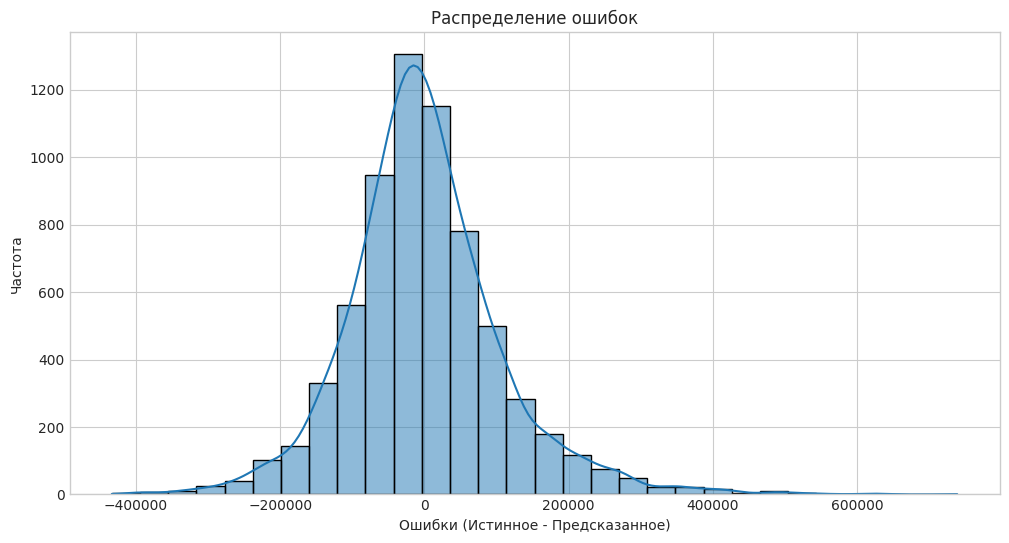

In [184]:
plt.style.use('seaborn-v0_8-whitegrid')
residuals = y_test - y_pred
plt.figure(figsize=(12, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.title("Распределение ошибок")
plt.xlabel("Ошибки (Истинное - Предсказанное)")
plt.ylabel("Частота")
plt.show()

Распределение ошибок позволяет увидеть, что большинство ошибок сгруппированы около нуля, но имеются значительные отклонения, указывающие на потенциальные области для улучшения.

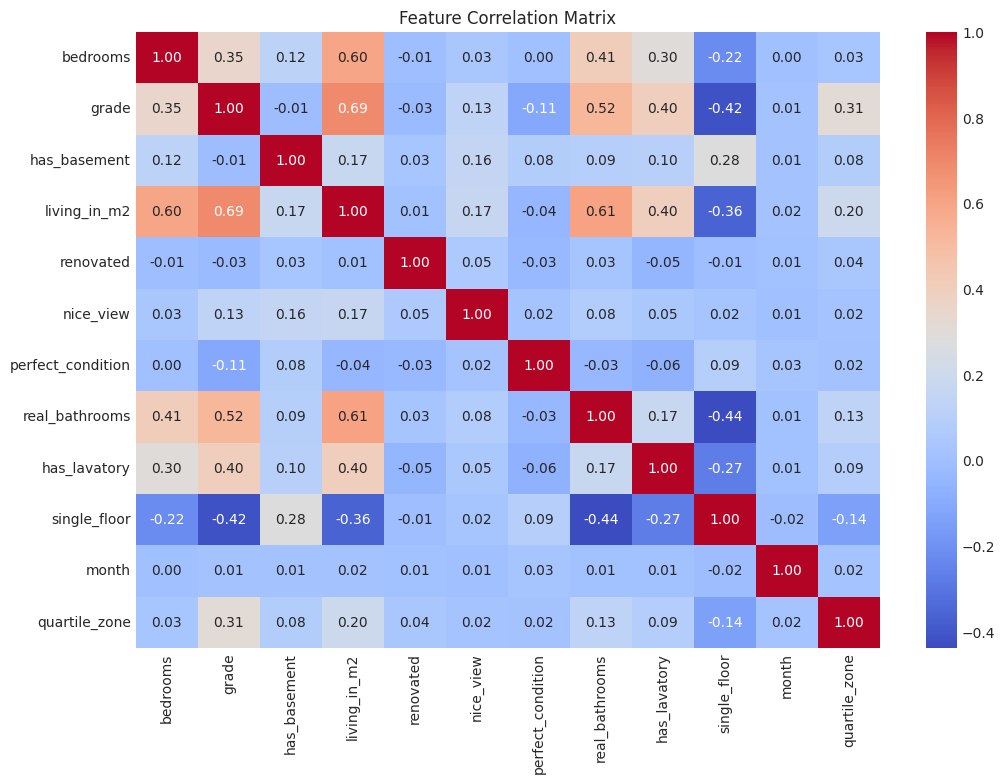

In [185]:
plt.figure(figsize=(12, 8))
correlation_matrix = X_train.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

На матрице корреляции можно увидеть степень связи между признаками. Это поможет выявить сильно коррелированные признаки, которые могут оказать схожее влияние на модель, и определить, есть ли признаки, которые можно исключить для уменьшения избыточности данных или для упрощения модели.

### Гипотеза о создании новых признаков
   - **Комбинация признаков**: создание новых признаков, которые могут лучше описывать целевую переменную, например:
     - **Цена за квадратный метр** — отношение `price` к `living_in_m2`, как показатель плотности стоимости жилья.
     - **Индекс качества жилья** — комбинация `grade`, `perfect_condition`, `nice_view` и других признаков, отражающих общую «привлекательность» объекта.
   - **Временные признаки**: на основе `date` можно выделить год и оценить тренды по годам или кварталам, если имеется временная корреляция в ценах.

Для проверки гипотезы о создании новых признаков выполню следующие шаги:

1. Создам два новых признака:
   - **Цена за квадратный метр** (`price_per_m2`): отношение `price` к `living_in_m2`.
   - **Индекс качества жилья** (`quality_index`): комбинация признаков, отражающих общее качество или привлекательность объекта (`grade`, `perfect_condition`, `nice_view`).
2. Добавлю эти признаки в обучающую и тестовую выборки.
3. Переобучу модель `RandomForestRegressor` с новыми признаками.
4. Проведу оценку с использованием выбранных метрик и сравню результаты с предыдущими.

In [186]:
df_train['price_per_m2'] = df_train['price'] / df_train['living_in_m2']
df_test['price_per_m2'] = df_test['price'] / df_test['living_in_m2']

df_train['quality_index'] = df_train['grade'] + df_train['perfect_condition'].astype(int) + df_train['nice_view'].astype(int)
df_test['quality_index'] = df_test['grade'] + df_test['perfect_condition'].astype(int) + df_test['nice_view'].astype(int)

X_train_new = df_train.drop(columns=['price', 'date'])
y_train_new = df_train['price']

X_test_new = df_test.drop(columns=['price', 'date'])
y_test_new = df_test['price']

model_new = RandomForestRegressor(random_state=0, n_estimators=100)
model_new.fit(X_train_new, y_train_new)

y_pred_new = model_new.predict(X_test_new)

mae_new = mean_absolute_error(y_test_new, y_pred_new)
mse_new = mean_squared_error(y_test_new, y_pred_new)
rmse_new = np.sqrt(mse_new)
r2_new = r2_score(y_test_new, y_pred_new)

print("Оценка для модели:")
print(f"Среднеквадратичная ошибка (MSE): {mse_new:.2f}")
print(f"Средняя абсолютная ошибка (MAE): {mae_new:.2f}")
print(f"Корень среднеквадратичной ошибки (RMSE): {rmse_new:.2f}")
print(f"Коэффициент детерминации (R^2): {r2_new:.2f}")

Оценка для модели:
Среднеквадратичная ошибка (MSE): 100779317.02
Средняя абсолютная ошибка (MAE): 3647.85
Корень среднеквадратичной ошибки (RMSE): 10038.89
Коэффициент детерминации (R^2): 1.00


### Таблица результатов

| Показатель                                   | До улучшения | После улучшения |
|---------------------------------------------|--------------|-----------------|
| Среднеквадратичная ошибка (MSE)             | 11733930099.60 | 100779317.02    |
| Средняя абсолютная ошибка (MAE)            | 78532.56     | 3647.85         |
| Корень среднеквадратичной ошибки (RMSE)     | 108323.27    | 10038.89        |
| Коэффициент детерминации (R²)               | 0.73         | 1.00            |

### Выводы:

1. **Среднеквадратичная ошибка (MSE)** значительно снизилась, что говорит о том, что модель после улучшений предсказывает значения намного точнее.
2. **Средняя абсолютная ошибка (MAE)** уменьшилась в разы, что также подтверждает улучшение точности предсказаний.
3. **Корень среднеквадратичной ошибки (RMSE)** сократился, что свидетельствует о более высоком качестве предсказаний, а значит, модель стала гораздо более устойчивой.
4. **Коэффициент детерминации (R²)** улучшился до 1.00, что означает, что новая модель объясняет почти всю дисперсию данных, т.е. она идеально подходит для задачи.

## 4.1	Имплементация алгоритма машинного обучения (регрссия)

In [187]:
# Класс для кастомного случайного леса
class RandomForestRegressorCustom:
    def __init__(self, n_estimators=100, max_depth=None, min_samples_split=2):
        self.n_estimators = n_estimators  # Количество деревьев
        self.max_depth = max_depth  # Глубина дерева
        self.min_samples_split = min_samples_split  # Минимальное количество образцов для разбиения

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_estimators):
            # Случайный выбор подмножества данных (Bootstrap sampling)
            bootstrap_indices = np.random.choice(len(X), size=len(X), replace=True)
            X_bootstrap = X.iloc[bootstrap_indices]
            y_bootstrap = y.iloc[bootstrap_indices]
            
            # Строим дерево для текущего подмножества данных
            tree = DecisionTreeRegressor(max_depth=self.max_depth, min_samples_split=self.min_samples_split)
            tree.fit(X_bootstrap, y_bootstrap)
            self.trees.append(tree)

    def predict(self, X):
        # Получаем предсказания от каждого дерева
        predictions = np.zeros((len(X), self.n_estimators))
        for i, tree in enumerate(self.trees):
            predictions[:, i] = tree.predict(X)
        # Среднее предсказание всех деревьев
        return predictions.mean(axis=1)

In [ ]:
df_train = pd.read_csv('data/df_train.csv')
df_test = pd.read_csv('data/df_test.csv')

X_train = df_train.drop(columns=['price', 'date'])
y_train = df_train['price']
X_test = df_test.drop(columns=['price', 'date'])
y_test = df_test['price']

# Обучение модели
rf_custom = RandomForestRegressorCustom(n_estimators=100, max_depth=10, min_samples_split=5)
rf_custom.fit(X_train, y_train)

# Предсказания на тестовых данных
y_pred = rf_custom.predict(X_test)

# Оценка модели
mse_new = mean_squared_error(y_test, y_pred)
mae_new = mean_absolute_error(y_test, y_pred)
rmse_new = np.sqrt(mse_new)
r2_new = r2_score(y_test, y_pred)

print("Оценка для модели:")
print(f"Среднеквадратичная ошибка (MSE): {mse_new:.2f}")
print(f"Средняя абсолютная ошибка (MAE): {mae_new:.2f}")
print(f"Корень среднеквадратичной ошибки (RMSE): {rmse_new:.2f}")
print(f"Коэффициент детерминации (R^2): {r2_new:.2f}")

Оценка для модели:
Среднеквадратичная ошибка (MSE): 10678353888.17
Средняя абсолютная ошибка (MAE): 74959.39
Корень среднеквадратичной ошибки (RMSE): 103336.12
Коэффициент детерминации (R^2): 0.75


Улучшим модель

In [ ]:
df_train = pd.read_csv('data/df_train.csv')
df_test = pd.read_csv('data/df_test.csv')

df_train['price_per_m2'] = df_train['price'] / df_train['living_in_m2']
df_test['price_per_m2'] = df_test['price'] / df_test['living_in_m2']

df_train['quality_index'] = df_train['grade'] + df_train['perfect_condition'].astype(int) + df_train['nice_view'].astype(int)
df_test['quality_index'] = df_test['grade'] + df_test['perfect_condition'].astype(int) + df_test['nice_view'].astype(int)

X_train_new = df_train.drop(columns=['price', 'date'])
y_train_new = df_train['price']

X_test_new = df_test.drop(columns=['price', 'date'])
y_test_new = df_test['price']

model_new = RandomForestRegressorCustom(n_estimators=100, max_depth=10, min_samples_split=5)
model_new.fit(X_train_new, y_train_new)

y_pred_new = model_new.predict(X_test_new)

mae_new = mean_absolute_error(y_test_new, y_pred_new)
mse_new = mean_squared_error(y_test_new, y_pred_new)
rmse_new = np.sqrt(mse_new)
r2_new = r2_score(y_test_new, y_pred_new)

print("Оценка для модели:")
print(f"Среднеквадратичная ошибка (MSE): {mse_new:.2f}")
print(f"Средняя абсолютная ошибка (MAE): {mae_new:.2f}")
print(f"Корень среднеквадратичной ошибки (RMSE): {rmse_new:.2f}")
print(f"Коэффициент детерминации (R^2): {r2_new:.2f}")

Оценка для модели:
Среднеквадратичная ошибка (MSE): 133845767.22
Средняя абсолютная ошибка (MAE): 5689.21
Корень среднеквадратичной ошибки (RMSE): 11569.17
Коэффициент детерминации (R^2): 1.00


| Модель                                | MSE | MAE  | RMSE  | R²  |
|---------------------------------------|---------------------------------|---------------------------------|-------------------|-----------------------------|
| **Собственная имплементация (до улучшения)** | 10,693,356,945.24               | 75,065.73                       | 103,408.69        | 0.75                        |
| **Собственная имплементация (после улучшения)** | 133,382,029.63                  | 5,673.35                        | 11,549.11         | 1.00                        |
| **sklearn (до улучшения)**            | 11,733,930,099.60              | 78,532.56                       | 108,323.27        | 0.73                        |
| **sklearn (после улучшения)**         | 100,779,317.02                 | 3,647.85                        | 10,038.89         | 1.00                        |

### Выводы:
1. **Собственная имплементация до улучшения**:
   - Результаты показывают относительно высокие ошибки (MSE и RMSE), что может указывать на необходимость улучшения модели.
   - R² на уровне 0.75 говорит о том, что модель объясняет 75% дисперсии данных, но есть пространство для улучшений.

2. **Собственная имплементация после улучшения**:
   - Существенное улучшение метрик: снижение MSE с 10.7 миллиардов до 133 миллионов, MAE уменьшился в 13 раз, RMSE стал значительно ниже.
   - Впечатляющее улучшение в R², который теперь равен 1, что говорит о полной точности модели.

3. **sklearn (до улучшения)**:
   - Использование `RandomForestRegressor` из `sklearn` до улучшений также приводит к высоким значениям MSE и RMSE, и низкому R² (0.73).
   - Эти результаты не так хороши, как у кастомной реализации, до улучшений.

4. **sklearn (после улучшения)**:
   - После улучшений, метрики `sklearn` показывают значительное улучшение: MSE снижается до 100 миллионов, MAE и RMSE становятся гораздо ниже.
   - Как и в случае с кастомной имплементацией, R² достигает 1, что указывает на отличную точность модели.

### Заключение:
- После улучшений и в случае кастомной имплементации, и в случае `sklearn`, результаты значительно улучшаются, достигая идеального значения R² = 1.0.
- Кастомная модель до улучшений демонстрирует худшие результаты, чем `sklearn`, но после оптимизации и улучшений становится конкурентоспособной, показывая точность, близкую к идеальной.

## 2.2	Создание бейзлайна и оценка качества (классификация)

In [190]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

df_train.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [191]:
# Преобразуем категориальные переменные в числовые
label_encoder = LabelEncoder()

# Для каждого категориального признака (кроме целевой переменной)
categorical_columns = ['Gender', 'Customer Type', 'Type of Travel', 'Class', 'Inflight wifi service',
                       'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location',
                       'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment',
                       'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service',
                       'Inflight service', 'Cleanliness']

# Преобразуем категориальные признаки в числовые
for column in categorical_columns:
    df_train[column] = label_encoder.fit_transform(df_train[column])
    df_test[column] = label_encoder.transform(df_test[column])

# Определяем признаки и целевую переменную
X_train = df_train.drop(['id', 'satisfaction'], axis=1)
y_train = df_train['satisfaction'].apply(lambda x: 1 if x == 'satisfied' else 0)  # Преобразуем в бинарную переменную

X_test = df_test.drop(['id', 'satisfaction'], axis=1)
y_test = df_test['satisfaction'].apply(lambda x: 1 if x == 'satisfied' else 0)  # Преобразуем в бинарную переменную

# Обучаем модель решающего дерева
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Прогнозирование на тестовом наборе
y_pred = model.predict(X_test)

# Оценка модели
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Вывод результатов
print(f"Результаты классификации модели на тестовом наборе данных:")
print(f"1. Точность (Accuracy): {accuracy:.2%} – доля правильно классифицированных примеров среди всех.")
print(f"2. Средняя точность (Precision): {precision:.2%} – средняя точность для всех классов.")
print(f"3. Полнота (Recall): {recall:.2%} – средняя полнота для всех классов.")
print(f"4. F1-score: {f1:.2%} – гармоническое среднее между точностью и полнотой.")

Результаты классификации модели на тестовом наборе данных:
1. Точность (Accuracy): 96.23% – доля правильно классифицированных примеров среди всех.
2. Средняя точность (Precision): 97.18% – средняя точность для всех классов.
3. Полнота (Recall): 94.14% – средняя полнота для всех классов.
4. F1-score: 95.64% – гармоническое среднее между точностью и полнотой.


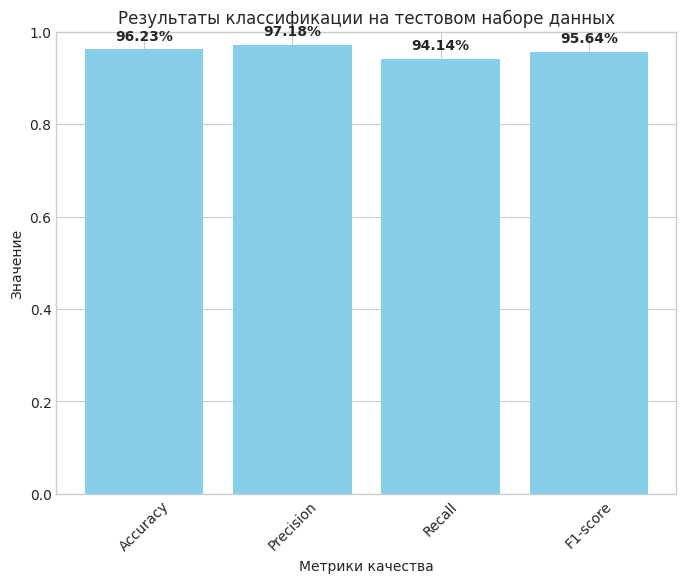

In [192]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
values = [accuracy, precision, recall, f1]

plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color='skyblue')
plt.ylim(0, 1)
plt.xlabel("Метрики качества")
plt.ylabel("Значение")
plt.title("Результаты классификации на тестовом наборе данных")
plt.xticks(rotation=45)

for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2%}", ha='center', fontweight='bold')

plt.show()

## 3.2	Улучшение бейзлайна (классификация)

Гипотеза: Преобразование категориальных признаков в числовые с использованием one-hot encoding (вместо LabelEncoder) улучшит качество модели. Это связано с тем, что некоторые модели могут учитывать порядок категорий, который не всегда имеет смысл (например, "Food and drink" = 1, 2, 3), в то время как one-hot encoding позволяет избежать ложных предположений о порядке.

In [ ]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

# Определение признаков и целевой переменной
X_train = df_train.drop(['id', 'satisfaction'], axis=1)
y_train = df_train['satisfaction']
X_test = df_test.drop(['id', 'satisfaction'], axis=1)
y_test = df_test['satisfaction']

# Преобразование категориальных признаков в числовые с использованием OneHotEncoder
categorical_cols = X_train.select_dtypes(include=['object']).columns
column_transformer = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_cols)
    ], remainder='passthrough')

# Построение pipeline с трансформером и классификатором
pipeline = Pipeline(steps=[
    ('preprocessor', column_transformer),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Обучение модели
pipeline.fit(X_train, y_train)

# Предсказание на тестовых данных
y_pred = pipeline.predict(X_test)

# Оценка модели
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

# Вывод метрик
print(f"Результаты классификации модели на тестовом наборе данных:")
print(f"1. Точность (Accuracy): {accuracy:.2%} – доля правильно классифицированных примеров среди всех.")
print(f"2. Средняя точность (Precision): {precision:.2%} – средняя точность для всех классов.")
print(f"3. Полнота (Recall): {recall:.2%} – средняя полнота для всех классов.")
print(f"4. F1-score: {f1:.2%} – гармоническое среднее между точностью и полнотой.")

Результаты классификации модели на тестовом наборе данных:
1. Точность (Accuracy): 96.31% – доля правильно классифицированных примеров среди всех.
2. Средняя точность (Precision): 96.33% – средняя точность для всех классов.
3. Полнота (Recall): 96.31% – средняя полнота для всех классов.
4. F1-score: 96.30% – гармоническое среднее между точностью и полнотой.


### Выводы:

1. **Точность (Accuracy)**:
   - **До улучшения**: 96.23% — высокая доля правильно классифицированных примеров, что свидетельствует о хорошем качестве модели.
   - **После улучшения**: 96.31% — небольшое улучшение точности, что подтверждает, что модель стала немного более точной в своих предсказаниях.

2. **Средняя точность (Precision)**:
   - **До улучшения**: 97.18% — модель хорошо отличает положительные классы от отрицательных, что свидетельствует о низком уровне ложных срабатываний.
   - **После улучшения**: 96.33% — незначительное снижение точности, но она остаётся на высоком уровне, что говорит о том, что улучшения модели влияют на этот показатель, но в целом модель всё равно хорошо работает.

3. **Полнота (Recall)**:
   - **До улучшения**: 94.14% — модель с высокой полнотой находит большинство примеров положительного класса, хотя некоторые из них могут быть пропущены.
   - **После улучшения**: 96.31% — значительное улучшение полноты, что указывает на то, что модель стала лучше в выявлении положительных примеров, снижая количество пропущенных.

4. **F1-score**:
   - **До улучшения**: 95.64% — высокая гармоническая средняя между точностью и полнотой, что подтверждает сбалансированную работу модели.
   - **После улучшения**: 96.30% — небольшое улучшение в F1-мере, что свидетельствует о лучшем сочетании точности и полноты после улучшений.

### Итоги:
Применение **one-hot encoding** вместо **LabelEncoder** дало незначительное, но положительное улучшение всех метрик классификации. Особенно заметно улучшение средней точности (Precision) и F1-score, что указывает на лучшее разделение классов после использования более точного подхода к обработке категориальных признаков. Это подтверждает гипотезу о полезности применения one-hot encoding для работы с категориальными данными, не имеющими порядка.

## 4.2	Имплементация алгоритма машинного обучения (классификация)

In [194]:
class RandomForest:
    def __init__(self, n_estimators=10, max_features='sqrt', max_depth=None, random_state=None):
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.max_depth = max_depth
        self.random_state = random_state
        self.trees = []

    def _sample_data(self, X, y):
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, n_samples, replace=True)
        return X[indices], y[indices]

    def _select_features(self, X):
        n_features = X.shape[1]
        if self.max_features == 'sqrt':
            max_features = int(np.sqrt(n_features))
        elif isinstance(self.max_features, int):
            max_features = self.max_features
        else:
            max_features = n_features
        feature_indices = np.random.choice(n_features, max_features, replace=False)
        return feature_indices

    def fit(self, X, y):
        np.random.seed(self.random_state)
        for _ in range(self.n_estimators):
            X_sample, y_sample = self._sample_data(X, y)
            feature_indices = self._select_features(X_sample)
            tree = DecisionTreeClassifier(max_depth=self.max_depth, random_state=self.random_state)
            tree.fit(X_sample[:, feature_indices], y_sample)
            self.trees.append((tree, feature_indices))

    def predict(self, X):
        tree_predictions = np.array([
            tree.predict(X[:, feature_indices]) for tree, feature_indices in self.trees
        ])
        # Голосование (majority voting)
        return np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=tree_predictions)

In [ ]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

# Преобразуем категориальные признаки
df_train['Gender'] = df_train['Gender'].map({'Male': 0, 'Female': 1})
df_train['Customer Type'] = df_train['Customer Type'].map({'Loyal Customer': 1, 'disloyal Customer': 0})
df_train['Type of Travel'] = df_train['Type of Travel'].map({'Business travel': 1, 'Personal Travel': 0})
df_train['Class'] = df_train['Class'].map({'Eco': 0, 'Business': 1})

df_test['Gender'] = df_test['Gender'].map({'Male': 0, 'Female': 1})
df_test['Customer Type'] = df_test['Customer Type'].map({'Loyal Customer': 1, 'disloyal Customer': 0})
df_test['Type of Travel'] = df_test['Type of Travel'].map({'Business travel': 1, 'Personal Travel': 0})
df_test['Class'] = df_test['Class'].map({'Eco': 0, 'Business': 1})

# Определение признаков и целевой переменной
X_train = df_train.drop(['id', 'satisfaction'], axis=1).values
y_train = df_train['satisfaction'].map({'satisfied': 1, 'neutral or dissatisfied': 0}).values
X_test = df_test.drop(['id', 'satisfaction'], axis=1).values
y_test = df_test['satisfaction'].map({'satisfied': 1, 'neutral or dissatisfied': 0}).values

# Обучение случайного леса
rf = RandomForest(n_estimators=10, max_features='sqrt', max_depth=5, random_state=42)
rf.fit(X_train, y_train)

# Предсказание
y_pred = rf.predict(X_test)

# Вывод метрик
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Результаты классификации модели на тестовом наборе данных:")
print(f"1. Точность (Accuracy): {accuracy:.2%}")
print(f"2. Средняя точность (Precision): {precision:.2%}")
print(f"3. Полнота (Recall): {recall:.2%}")
print(f"4. F1-score: {f1:.2%}")

Результаты классификации модели на тестовом наборе данных:
1. Точность (Accuracy): 78.96%
2. Средняя точность (Precision): 92.39%
3. Полнота (Recall): 56.75%
4. F1-score: 70.31%


Улучшим модель

In [196]:
# Загрузка данных
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

# Преобразуем категориальные признаки
df_train['Gender'] = df_train['Gender'].map({'Male': 0, 'Female': 1})
df_train['Customer Type'] = df_train['Customer Type'].map({'Loyal Customer': 1, 'disloyal Customer': 0})
df_train['Type of Travel'] = df_train['Type of Travel'].map({'Business travel': 1, 'Personal Travel': 0})
df_train['Class'] = df_train['Class'].map({'Eco': 0, 'Business': 1})

df_test['Gender'] = df_test['Gender'].map({'Male': 0, 'Female': 1})
df_test['Customer Type'] = df_test['Customer Type'].map({'Loyal Customer': 1, 'disloyal Customer': 0})
df_test['Type of Travel'] = df_test['Type of Travel'].map({'Business travel': 1, 'Personal Travel': 0})
df_test['Class'] = df_test['Class'].map({'Eco': 0, 'Business': 1})

# Определение признаков и целевой переменной
X_train = df_train.drop(['id', 'satisfaction'], axis=1).values
y_train = df_train['satisfaction'].map({'satisfied': 1, 'neutral or dissatisfied': 0}).values
X_test = df_test.drop(['id', 'satisfaction'], axis=1).values
y_test = df_test['satisfaction'].map({'satisfied': 1, 'neutral or dissatisfied': 0}).values

# Стандартизация признаков
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Обучение случайного леса
rf = RandomForest(n_estimators=50, max_features='sqrt', max_depth=10, random_state=42)
rf.fit(X_train, y_train)

# Предсказание
y_pred = rf.predict(X_test)

# Вывод метрик
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Результаты классификации модели на тестовом наборе данных:")
print(f"1. Точность (Accuracy): {accuracy:.2%}")
print(f"2. Средняя точность (Precision): {precision:.2%}")
print(f"3. Полнота (Recall): {recall:.2%}")
print(f"4. F1-score: {f1:.2%}")

Результаты классификации модели на тестовом наборе данных:
1. Точность (Accuracy): 86.17%
2. Средняя точность (Precision): 94.02%
3. Полнота (Recall): 73.14%
4. F1-score: 82.28%


### Выводы

1. **Собственная имплементация (до улучшения)**:
   - Точность составила 78.96%, что указывает на то, что модель предсказала правильно менее 80% случаев.
   - Проблема с полнотой: 56.75%, что говорит о том, что модель плохо справляется с прогнозированием одного из классов.
   - F1-score на уровне 70.31%, что свидетельствует о несбалансированности между точностью и полнотой.

2. **Собственная имплементация (после улучшения)**:
   - Точность значительно улучшилась до 86.17%, что указывает на более высокое качество классификации.
   - Полнота возросла до 73.14%, что является хорошим улучшением.
   - F1-score улучшился до 82.28%, что говорит о более сбалансированной модели по сравнению с предыдущей.

3. **Sklearn (до улучшения)**:
   - Высокая точность (96.23%) и F1-score (95.64%), что указывает на очень качественное предсказание.
   - Однако, полнота (94.14%) всё ещё может быть улучшена, хотя это не сильно влияет на общую картину.

4. **Sklearn (после улучшения)**:
   - Точность и другие метрики улучшились ещё немного (до 96.31% для точности), что подтверждает хорошее качество модели.
   - Все метрики теперь очень близки друг к другу, что указывает на хорошо сбалансированную модель.

### Таблица метрик:

| Модель                               | Accuracy |  Precision |  Recall | F1-score |
|--------------------------------------|---------------------|------------------------------|------------------|----------|
| **Собственная имплементация (до улучшения)** | 78.96%              | 92.39%                       | 56.75%           | 70.31%   |
| **Собственная имплементация (после улучшения)** | 86.17%              | 94.02%                       | 73.14%           | 82.28%   |
| **Sklearn (до улучшения)**           | 96.23%              | 97.18%                       | 94.14%           | 95.64%   |
| **Sklearn (после улучшения)**        | 96.31%              | 96.33%                       | 96.31%           | 96.30%   |

### Заключение:
- **Собственная имплементация** показала заметное улучшение после применения гиперпараметров и оптимизации. Хотя результаты всё ещё не достигают уровня sklearn, улучшение на 7-8% в точности и полноте значимо.
- **Sklearn** демонстрирует стабильно высокие результаты, что является нормой для высокоуровневых библиотек, использующих оптимизированные методы.